# Validation of sag map with Bertin

In [1]:
# Imports
import copy
import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.patches import Rectangle
from optical import rectangular_sw_substrate, rectangular_lw_substrate

Define new substrates with surfaces defined wrt substrate center instead of EGA

In [2]:
rectangular_lw_substrate_center = copy.deepcopy(rectangular_lw_substrate)
rectangular_sw_substrate_center = copy.deepcopy(rectangular_sw_substrate)

for substrate_ega, substrate_center in zip([rectangular_lw_substrate, rectangular_sw_substrate],
                                           [rectangular_lw_substrate_center, rectangular_sw_substrate_center]):
    substrate_center.aperture.dx = 0 # By definition of substrate defined wrt its center
    substrate_center.aperture.dy = 0
    # By definition aperture is centered on substrate
    substrate_center.surface.dx = substrate_ega.surface.dx - substrate_ega.aperture.dx
    substrate_center.surface.dy = substrate_ega.surface.dy - substrate_ega.aperture.dy
    # Compute center sag in EGA coordinates
    # Use the native substrate grid to use interpolation with neighbors
    j_mid, i_mid = substrate_ega.grid()[0].shape[0] // 2, substrate_ega.grid()[0].shape[1] // 2
    # Sag at center of substrate in EGA coordinates
    substrate_center.surface.dz = substrate_ega.surface.dz - substrate_ega.sag()[j_mid, i_mid]

Coordinates used by Bertin to compute the sag in the frame of reference centered on the substrate

In [3]:
bertin_center_x = [0, -30, -20, -10, 10, 20, 30, 0, 0, 0, 0, 0, 0, 0, 0, -30, -30, 30, 30]
bertin_center_y = [0, 0, 0, 0, 0, 0, 0, -40, -30, -20, -10, 10, 20, 30, 40, -40, 40, 40, -40]

Define a regular x & y vectors in the frame of the substrate center, using 2 points of margin to prevent edge effects
The vectors are designed to contain the position values used by Bertin
The values are the same for both substrates because they are relative to the substrate center

In [4]:
dx = dy = 0.2  # [mm] spatial resolution for all sag computations
n_margin = 5 # number of points of margin
x_min, x_max = min(bertin_center_x) - n_margin * dx, max(bertin_center_x) + n_margin * dx
y_min, y_max = min(bertin_center_y) - n_margin * dy, max(bertin_center_y) + n_margin * dy
nx = int((x_max - x_min) / dx)
nx += (nx + 1) % 2
ny = int((y_max - y_min) / dy)
ny += (ny + 1) % 2
x_bertin_resampled = np.linspace(x_min, x_max, nx)
y_bertin_resampled = np.linspace(y_min, y_max, ny)
# indices of the original Bertin coordinates in the new, finely gridded, vectors
ix = [int((len(x_bertin_resampled) - 1) * (bx - x_min) / (x_max - x_min)) for bx in bertin_center_x]
iy = [int((len(y_bertin_resampled) - 1) * (by - y_min) / (y_max - y_min)) for by in bertin_center_y]

0.0019396225736656447 0.0004728959993824125 8.17479622006763e-05
Angles : alpha=0.34653°, beta=0.77333° gamma=0.00468°
0.17602015800477488 0.03225530899615924 0.0018761623103056174
Angles : alpha=3.16398°, beta=-5.07982° gamma=-0.28043°


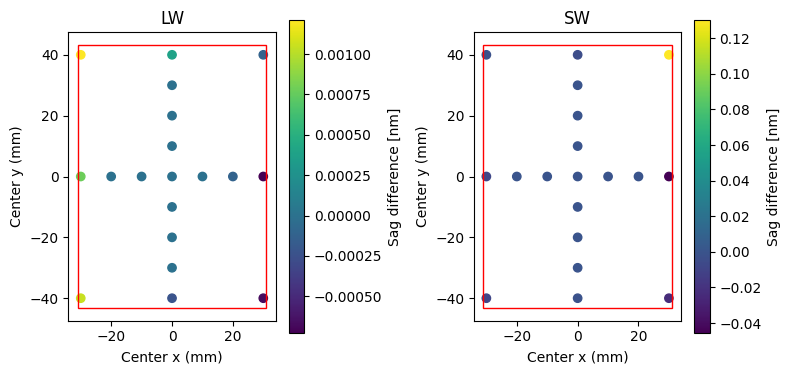

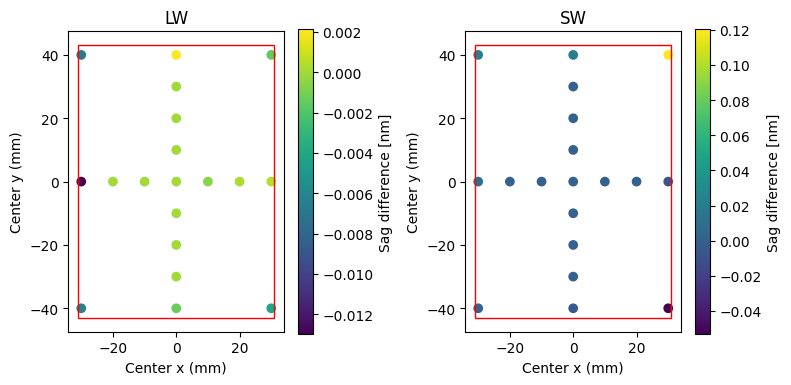

In [5]:
# Comparison of sags computed using the two substrate definitions

fig1, axes1 = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
fig2, axes2 = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))

for name, substrate_ega, substrate_center, ax1, ax2 in zip(['LW', 'SW'],
                                                           [rectangular_lw_substrate, rectangular_sw_substrate],
                                                           [rectangular_lw_substrate_center, rectangular_sw_substrate_center],
                                                           axes1, axes2):
    # Translate the substrate points to the substrate frame (EGA & center) and define the corresponding grid
    x = x_bertin_resampled + substrate_ega.aperture.dx
    y = y_bertin_resampled + substrate_ega.aperture.dy
    grid_ega = np.meshgrid(x, y)
    sag_ega = substrate_ega.sag(grid_ega)[(iy, ix)]

    x = x_bertin_resampled + substrate_center.aperture.dx
    y = y_bertin_resampled + substrate_center.aperture.dy
    grid_center = np.meshgrid(x, y)
    sag_center = substrate_center.sag(grid_center)[(iy, ix)]

    delta = sag_ega - sag_center
    # compensate sag difference at substrate center between the two definitions
    delta -= substrate_ega.surface.dz - substrate_center.surface.dz
    delta *= 1e6 # convert to [nm]
    print(np.nanmax(delta) - np.nanmin(delta), np.nanstd(delta), np.nanmean(delta))
    sc = ax1.scatter(bertin_center_x, bertin_center_y, c=delta)
    bar = fig1.colorbar(sc, ax=ax1)
    bar.set_label('Sag difference [nm]')
    ax1.set_title(name)
    ax1.set_aspect('equal')
    ax1.set_xlabel('Center x (mm)')
    ax1.set_ylabel('Center y (mm)')
    # Draw aperture of rectangular substrate
    rect = Rectangle((substrate_center.aperture.dx - substrate_center.aperture.x_width / 2,
                      substrate_center.aperture.dy - substrate_center.aperture.y_width / 2),
                      substrate_center.aperture.x_width,
                      substrate_center.aperture.y_width,
                      color='red', fill=None)
    ax1.add_patch(rect)

    # Create a surface identical to that of the substrate,
    # but defined in its 'native' coordinates, ie with no shift and no tilt
    native_surface = copy.deepcopy(substrate_ega.surface)
    native_surface.dx, native_surface.dy, native_surface.dz = 0, 0, 0
    native_surface.alpha, native_surface.beta, native_surface.gamma = 0, 0, 0

    # define a regular grid in the surface native coordinates with enough margin to cover the substrate
    x_half_width = int(substrate_center.aperture.x_width / 2 + abs(substrate_center.surface.dx) + 2 * dx)
    y_half_width = int(substrate_center.aperture.y_width / 2 + abs(substrate_center.surface.dy) + 2 * dy)
    nx = int(2 * x_half_width / dx)
    nx += (nx + 1) % 2
    ny = int(2 * y_half_width / dy)
    ny += (ny + 1) % 2
    x_surface_native, y_surface_native = np.meshgrid(np.linspace(-x_half_width, x_half_width, nx),
                                                     np.linspace(-y_half_width, y_half_width, ny))
    # compute the corresponding sag
    z_surface_native = native_surface.sag((x_surface_native, y_surface_native))

    # Transform the coordinates from surface to substrate center coordinates
    xyz = np.stack((x_surface_native.ravel(),
                    y_surface_native.ravel(),
                    z_surface_native.ravel(),
                    np.ones(x_surface_native.size)))
    x_surface_center, y_surface_center, z_surface_center = substrate_center.surface.inverse_rotation_matrix() @ xyz

    xy = (grid_center[0].flatten(), grid_center[1].flatten())
    z = griddata((x_surface_center, y_surface_center), z_surface_center, xy, rescale=True, method='cubic').reshape(grid_center[0].shape)[iy, ix]

    delta = sag_center - z
    delta *= 1e6 # convert to [nm]

    sc = ax2.scatter(bertin_center_x, bertin_center_y, c=delta)
    bar = fig2.colorbar(sc, ax=ax2)
    bar.set_label('Sag difference [nm]')
    ax2.set_title(name)
    ax2.set_aspect('equal')
    ax2.set_xlabel('Center x (mm)')
    ax2.set_ylabel('Center y (mm)')
    # Draw aperture of rectangular substrate
    rect = Rectangle((substrate_center.aperture.dx - substrate_center.aperture.x_width / 2,
                      substrate_center.aperture.dy - substrate_center.aperture.y_width / 2),
                      substrate_center.aperture.x_width,
                      substrate_center.aperture.y_width,
                      color='red', fill=None)
    ax2.add_patch(rect)
    # The Euler angles corresponding to the ellipse to center matrix are obtained using:
    rotation = Rotation.from_matrix(substrate_ega.surface.inverse_rotation_matrix()[:, 0:3])
    angles = rotation.as_euler('xyz', degrees=True)
    print(f'Angles : alpha={angles[0]:.5f}°, beta={angles[1]:.5f}° gamma={angles[2]:.5f}°')
